## Twitter Archive

In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from functools import reduce
import numpy as np
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import csv

Twitter Archive includes a csv of tweets, so we'll use that

##### Load and Simple Cleanse 

In [2]:
# csv is in poor shape, and we need to strip some newline data
fname = "../archive_dec16/tweets.csv"
cname = "../archive_dec16/cleantweets.csv"

# how we want to clean some srings (uses reduce)
repls = {'\n': '', ',':''}

def string_clean(text):
    for i, j in repls.items():
        text = text.replace(i, j)
    return text

# simple data conversion
str2date = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S %z')
str2len = lambda x: len(x)

tweet_data = []

with open(fname, "r", encoding="utf8") as input:
    reader = csv.reader(input)
    next(reader, None) # skip headers
    for record in reader:
        clean_row = tuple(string_clean(s) for s in record)
        # in this simple example we only care for timestamp & text
        tweet_data.append((str2date(clean_row[3]),str2len(clean_row[5])))
        
num_tweets = len(tweet_data)
    
print(num_tweets)
print(tweet_data[1:10])

375
[(datetime.datetime(2018, 12, 16, 16, 35, 41, tzinfo=datetime.timezone.utc), 29), (datetime.datetime(2018, 12, 16, 16, 35, 17, tzinfo=datetime.timezone.utc), 51), (datetime.datetime(2018, 12, 16, 14, 54, 9, tzinfo=datetime.timezone.utc), 206), (datetime.datetime(2018, 12, 13, 15, 13, 45, tzinfo=datetime.timezone.utc), 53), (datetime.datetime(2018, 12, 10, 21, 31, 3, tzinfo=datetime.timezone.utc), 89), (datetime.datetime(2018, 12, 10, 21, 28, 39, tzinfo=datetime.timezone.utc), 60), (datetime.datetime(2018, 12, 9, 13, 16, 3, tzinfo=datetime.timezone.utc), 56), (datetime.datetime(2018, 12, 9, 12, 32, 21, tzinfo=datetime.timezone.utc), 63), (datetime.datetime(2018, 12, 9, 12, 29, 30, tzinfo=datetime.timezone.utc), 43)]


Shape looks right. I haven't hit the 1k mark yet... and 375 might seem like a small dataset, but Im sure we gather some good insights. 

##### Transform data

we need to transform the data into relevant info for this example, something like:  

  <p style="text-align: center;">date : <em>tweeting score</em> </p>
  
  tweeting score will include a total count of tweets as well as total words for the day, for now it'll just be a simple calculation
  
  <p style="text-align: center;"><em>single day tweeting score</em> = total tweets + total words </p>

In [5]:
agg_data = dict()

tweet_weight = 100 # idk, act of tweeting itself should count for something

# data needs to be reversed for time series
tweet_data = tweet_data[::-1] 

# simple dates
for item in tweet_data:
    dt = item[0]
    key = datetime(dt.year, dt.month, dt.day)
    if key in agg_data:
        agg_data[key] = agg_data[key] + item[1] + tweet_weight
    else:
        agg_data[key] = item[1] + tweet_weight

dates = list(agg_data.keys())

# creates list of all dates since Dec 16 
date_set = set(dates[0] + timedelta(x) for x in range((dates[-1] - dates[0]).days))

# add missing dates
for item in date_set:
    dt = item
    key = datetime(dt.year, dt.month, dt.day)
    if key not in agg_data:
        agg_data[key] = 0
    

tscores = np.array(list(agg_data.values()))
all_dates = np.array(list(agg_data.keys()))
all_dates = all_dates.astype('str',copy=False)

# data needs to be organized by dates
sort_by_dates = all_dates.argsort()

all_dates = all_dates[sort_by_dates]
tscores = tscores[sort_by_dates]


n_tscores = len(tscores)
print(len(all_dates), len(tscores))

print(all_dates[1:10])
print(tscores[1:10])


1504 1504
['2014-11-05 00:00:00' '2014-11-06 00:00:00' '2014-11-07 00:00:00'
 '2014-11-08 00:00:00' '2014-11-09 00:00:00' '2014-11-10 00:00:00'
 '2014-11-11 00:00:00' '2014-11-12 00:00:00' '2014-11-13 00:00:00']
[398 172   0   0   0 157   0 239 154]


##### Simple Visualize

(0, 1504)

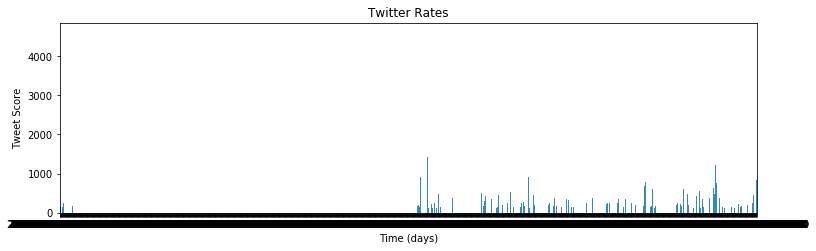

In [7]:
figsize(12.5, 3.5)

plt.bar(all_dates, tscores, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("Tweet Score")
plt.title("Twitter Rates")
plt.xlim(0, n_tscores)
